In [3]:
import pickle
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from tqdm import tqdm
from joblib import Parallel, delayed
import imageio.v3 as imageio

/tmp/ipykernel_42980/826563499.py:6: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [47]:
for base_dir in glob('/mnt/sdb1/home/kbotashev/iros_paper/replica_dataset_1/results/solutions/*'):
    for room_dir in glob(os.path.join(base_dir, '*')):
        for frame_dir in glob(os.path.join(room_dir, '*')):
            for iou_dir in glob(os.path.join(frame_dir, '*')):
                if len(glob(os.path.join(iou_dir, '*'))) > 16:
                    print(len(glob(os.path.join(iou_dir, '*'))), iou_dir)

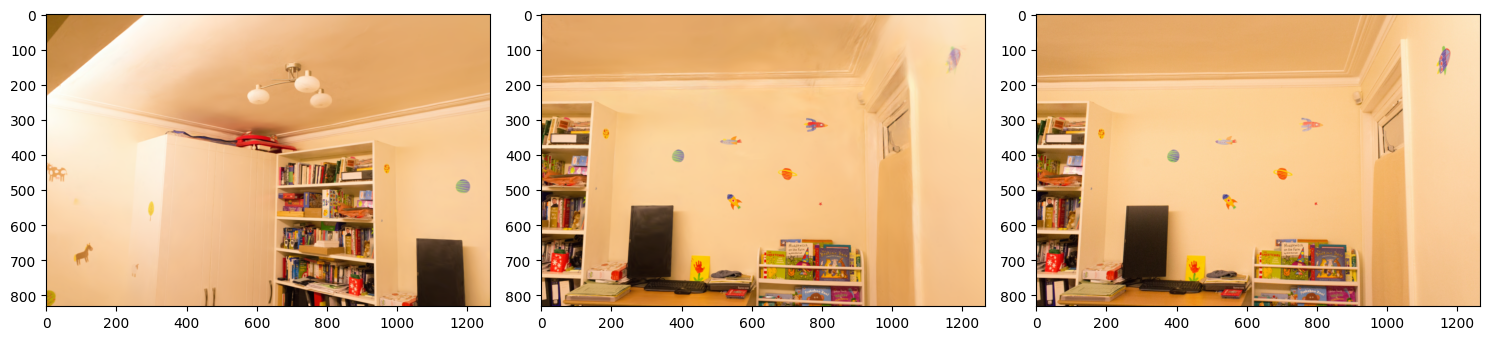

In [100]:
pickle_path_orig = '/mnt/sdb1/home/kbotashev/iros_paper/ibr_dataset/results/solutions/lietorch_l1_adam_1_2000_0.01_1e-05_0_0_5e-05_coarse_max_scale--2.5-num_tries--5-blur_2d_c2f_kernel_size--200-blur_2d_c2f_schedule--0.05-0.025-0.0125-0.00625-0.00625-0.0-0.0-0.0-0.0-0.0/playroom/DSC05572/000/DSC05633_004_DSC05572_1.pickle'
with open(pickle_path_orig, 'rb') as f:
    res = pickle.load(f)
f, axarr = plt.subplots(1,3, figsize = (15,5))
axarr[0].imshow((res['image_init']))
axarr[1].imshow(res['image_result'])
axarr[2].imshow(res['image_gt'])
plt.tight_layout()
plt.show()

In [4]:
def qvec2rotmat(qvec):
    return np.array([
        [1 - 2 * qvec[2]**2 - 2 * qvec[3]**2,
         2 * qvec[1] * qvec[2] - 2 * qvec[0] * qvec[3],
         2 * qvec[3] * qvec[1] + 2 * qvec[0] * qvec[2]],
        [2 * qvec[1] * qvec[2] + 2 * qvec[0] * qvec[3],
         1 - 2 * qvec[1]**2 - 2 * qvec[3]**2,
         2 * qvec[2] * qvec[3] - 2 * qvec[0] * qvec[1]],
        [2 * qvec[3] * qvec[1] - 2 * qvec[0] * qvec[2],
         2 * qvec[2] * qvec[3] + 2 * qvec[0] * qvec[1],
         1 - 2 * qvec[1]**2 - 2 * qvec[2]**2]])

def qvec2rotmat_reversed(qvec_reversed):
    qvec = qvec_reversed[[6,3,4,5]]
    return np.array([
        [1 - 2 * qvec[2]**2 - 2 * qvec[3]**2,
         2 * qvec[1] * qvec[2] - 2 * qvec[0] * qvec[3],
         2 * qvec[3] * qvec[1] + 2 * qvec[0] * qvec[2]],
        [2 * qvec[1] * qvec[2] + 2 * qvec[0] * qvec[3],
         1 - 2 * qvec[1]**2 - 2 * qvec[3]**2,
         2 * qvec[2] * qvec[3] - 2 * qvec[0] * qvec[1]],
        [2 * qvec[3] * qvec[1] - 2 * qvec[0] * qvec[2],
         2 * qvec[2] * qvec[3] + 2 * qvec[0] * qvec[1],
         1 - 2 * qvec[1]**2 - 2 * qvec[2]**2]])

In [97]:
R_gt = res['R_gt']
t_gt = res['t_gt']

In [98]:
R_result = qvec2rotmat_reversed(res['qtvec_result'])
t_result = res['qtvec_result'][:3]

In [5]:
def compute_pose_error(R_w2c_gt, t_w2c_gt, R_w2c_result, t_w2c_result):
    dt = np.linalg.norm(t_w2c_gt - t_w2c_result)
    cos = np.clip(((np.trace(R_w2c_gt @ R_w2c_result.T)) - 1) / 2, -1, 1)
    dR = np.rad2deg(np.abs(np.arccos(cos)))
    return dR, dt

In [100]:
rotation_error, translation_error = compute_pose_error(R_gt, t_gt, R_result, t_result)

In [101]:
sparse_result = np.load('/mnt/sdb1/home/kbotashev/iros_paper/replica_dataset_1/scenes/apartment_1/spsg_gt_colmap_localization_results/00001.npz')
qvec2rotmat(sparse_result['qvec']), sparse_result['tvec']
compute_pose_error(R_gt, t_gt, R_result, t_result)
compute_pose_error(R_gt, t_gt, qvec2rotmat(sparse_result['qvec']), sparse_result['tvec'])

In [47]:
np.load('/mnt/sdb1/home/kbotashev/iros_paper/replica_dataset_1/scenes/office_2/vladnet_results/00007.npz')['top_k_refs']

array(['office_2_rebase/images/00096.png',
       'office_2_rebase/images/00158.png',
       'office_2_rebase/images/00165.png',
       'office_2_rebase/images/00105.png',
       'office_2_rebase/images/00118.png',
       'office_2_rebase/images/00172.png',
       'office_2_rebase/images/00121.png',
       'office_2_rebase/images/00104.png',
       'office_2_rebase/images/00122.png',
       'office_2_rebase/images/00110.png'], dtype='<U32')

In [58]:
sparse_res_files = ['image_name', 'top_k_refs']
full_result_sparse = []
sparse_result_paths = glob('/mnt/sdb1/home/kbotashev/iros_paper/ibr_dataset/scenes/*/vladnet_results/*.npz')
for sparse_result_path in tqdm(sparse_result_paths):
    sparse_result = np.load(sparse_result_path)
    sparse_result_list = [sparse_result[file].tolist() for file in sparse_result.files]

    room_name = sparse_result_path.split('/')[-3]
    frame_id = sparse_result_path.split('/')[-1].split('.npz')[0]

    sparse_result_list += [room_name, frame_id]
    # print(sparse_result_list)
    # break
    full_result_sparse.append(sparse_result_list)
result_columns = ['image_name', 'top_k_refs', 'room_name', 'frame_id']
result_pd = pd.DataFrame(full_result_sparse, columns = result_columns)

100%|██████████| 62/62 [00:00<00:00, 2875.16it/s]


In [60]:
result_pd.to_csv('/mnt/sdb1/home/kbotashev/iros_paper/ibr_dataset/results/sparse_results_top5.csv')

In [87]:
sparse_res_files = ['image_name', 'top_k_refs', 'num_of_points', 'num_of_inliers', 'qvec', 'tvec', 'qvec_init', 'tvec_init']
full_result_sparse = []
sparse_result_paths = glob('/mnt/sdb1/home/kbotashev/iros_paper/replica_dataset_1/scenes/*/spsg_gt_colmap_localization_results/*.npz')
for sparse_result_path in tqdm(sparse_result_paths):
    sparse_result = np.load(sparse_result_path)
    sparse_result_list = [sparse_result[file] for file in sparse_result.files]

    room_name = sparse_result_path.split('/')[-3]
    frame_id = sparse_result_path.split('/')[-1].split('.npz')[0]
    model_result_path = glob(os.path.join('/mnt/sdb1/home/kbotashev/iros_paper/replica_dataset_1/results_methods/solutions/*', room_name, frame_id, '*/*.pickle'))[0]
    with open(model_result_path, 'rb') as f:
        res = pickle.load(f)
    R_gt = res['R_gt']
    t_gt = res['t_gt']
    qvec_gt = res['qvec_gt']
    if len(sparse_result.files) < 8:
        sparse_result_list += [None, None, None, None, None, None, None, None, 0, 0, 0, qvec_gt, t_gt, room_name, frame_id]
        full_result_sparse.append(sparse_result_list)
        continue
    dR, dt = compute_pose_error(R_gt, t_gt, qvec2rotmat(sparse_result['qvec']), sparse_result['tvec'])
    success_rot = 1 if dR < 5  else 0
    success_t = 1 if dt < 0.05 else 0
    success_combined = 1 if success_rot and success_t else 0
    sparse_result_list += [dR, dt, success_rot, success_t, success_combined, qvec_gt, t_gt, room_name, frame_id]
    full_result_sparse.append(sparse_result_list)
result_columns = ['image_name', 'top_k_refs', 'num_of_points', 'num_of_inliers', 'qvec_result', 'tvec_result', 
                  'qvec_init', 'tvec_init', 'rot_err_deg', 't_error_cm', 'success_rot', 'success_t', 'success_combined', 'qvec_gt', 't_gt', 'room_name', 'frame_id']
result_pd = pd.DataFrame(full_result_sparse, columns = result_columns)

100%|██████████| 160/160 [00:00<00:00, 194.39it/s]


In [92]:
result_pd.to_csv('/mnt/sdb1/home/kbotashev/iros_paper/replica_dataset_1/results_methods/sparse_full_results_combined.csv')

In [129]:
task_data = []
for pickle_path_orig in tqdm(glob('/mnt/sdb1/home/kbotashev/iros_paper/ibr_dataset/results/solutions/*/*/*/*/*.pickle')):
    if os.path.getsize(pickle_path_orig) == 0:     
        print(pickle_path_orig)
    task_data.append({'pickle_path_orig':pickle_path_orig})

100%|██████████| 305/305 [00:00<00:00, 147772.06it/s]


In [130]:
def load_data(pickle_path_orig):
    with open(pickle_path_orig, 'rb') as f:
        res = pickle.load(f)
    keys = list(res.keys())
    for key in keys:
        if type(res[key]) == np.ndarray:
            res[key] = res[key].tolist()
        if key in ['image_init', 'image_gt', 'image_result']:
            del res[key]

    res_pd = pd.DataFrame.from_dict(res, orient='index').transpose()
    return res_pd

resulting_pds = Parallel(n_jobs=64)(
delayed(load_data)(**x)
for x in tqdm(task_data, desc='Preparing valid data'))
print('---')

Preparing valid data: 100%|██████████| 305/305 [00:12<00:00, 24.82it/s]


---


In [131]:
full_result = pd.concat(resulting_pds)

In [132]:
full_result = full_result.reset_index(drop=True)

In [136]:
full_result.to_csv('/mnt/sdb1/home/kbotashev/iros_paper/ibr_dataset/results/full_results_combined.csv')

In [22]:
full_result.to_csv('/mnt/sdb1/home/kbotashev/iros_paper/replica_dataset_1/results_res4/full_results_combined_res48.csv')

In [135]:
with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 3,
                       ):
    print(full_result.groupby(['room_name', 'solving_method', 'iou_bin'], as_index=False)['success_combined'].value_counts(normalize=True))

   room_name solving_method  iou_bin  success_combined  proportion
0  drjohnson         coarse        0                 0       0.600
1  drjohnson         coarse        0                 1       0.400
2   playroom         coarse        0                 0       0.614
3   playroom         coarse        0                 1       0.386


In [138]:
full_result_groups d

rot_err_deg  t_error_cm  success_rot  success_t  \
room_name frame_name                                                    
drjohnson IMG_6292       5.826561    0.785053          0.6        0.6   
          IMG_6301      48.342375    3.594649          0.2        0.2   
          IMG_6313       7.986439    0.642229          0.8        0.2   
          IMG_6322      11.201311    1.237254          0.6        0.6   
          IMG_6332       8.986156    0.842512          0.6        0.6   
...                           ...         ...          ...        ...   
playroom  DSC05771     100.408319    4.182294          0.0        0.0   
          DSC05780      11.266508    1.278551          0.6        0.6   
          DSC05788       3.108486    0.769453          0.8        0.6   
          DSC05797       0.158871    0.013506          1.0        1.0   
          DSC05805      21.745993    1.784132          0.6        0.4   

                      success_combined  
room_name frame_name                    
drjohnson IMG_6292                 0.6  
          IMG_6301                 0.2  
          IMG_6313                 0.2  
          IMG_6322                 0.6  
          IMG_6332                 0.6  
...                                ...  
playroom  DSC05771                 0.0  
          DSC05780                 0.6  
          DSC05788                 0.6  
          DSC05797                 1.0  
          DSC05805                 0.4  

[61 rows x 5 columns]

In [139]:
full_result['iou_value'] 

room_name    frame_name
apartment_1  9             0.2
             17            0.2
             24            0.2
             25            0.2
office_2     12            0.2
             14            0.2
             27            0.2
             29            0.2
Name: success_combined, dtype: float64

In [133]:
R_results = []
t_results = []
rot_errors = []
t_errors = []
success_rots = []
success_ts = []
success_combineds = []
for i, row in tqdm(full_result.iterrows(), total = len(full_result)):
    R_result = qvec2rotmat_reversed(np.array(row['qtvec_result']))
    t_result = np.array(row['qtvec_result'][:3])
    rot_error, t_error = compute_pose_error(row['R_gt'], row['t_gt'], R_result, t_result)
    success_rot = 1 if rot_error < 10  else 0
    success_t = 1 if t_error < 0.1 else 0
    success_combined = 1 if success_rot and success_t else 0
    R_results.append(R_result.tolist())
    t_results.append(t_result.tolist())
    rot_errors.append(rot_error)
    t_errors.append(t_error)
    success_rots.append(success_rot)
    success_ts.append(success_t)
    success_combineds.append(success_combined)

100%|██████████| 305/305 [00:00<00:00, 6457.86it/s]


In [134]:
full_result['R_result'] = R_results
full_result['t_result'] = t_results
full_result['rot_err_deg'] = rot_errors
full_result['t_error_cm'] = t_errors
full_result['success_rot'] = success_rots
full_result['success_t'] = success_ts
full_result['success_combined'] = success_combineds

In [91]:
full_result.reset_index(drop=True).to_csv('/mnt/sdb1/home/kbotashev/iros_paper/replica_dataset_1/results_task_rebase_vladnet/full_results_task_rebase_vladnet.csv')

In [50]:
full_result = pd.read_csv('/mnt/sdb1/home/kbotashev/iros_paper/replica_dataset_1/results_methods/full_results_combined.csv')

/tmp/ipykernel_26636/139101503.py:1: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  full_result = pd.read_csv('/mnt/sdb1/home/kbotashev/iros_paper/replica_dataset_1/results_methods/full_results_combined.csv')


In [52]:
result_res48 = pd.read_csv('/mnt/sdb1/home/kbotashev/iros_paper/replica_dataset_1/results_res4/full_results_combined_res48.csv')

In [66]:
result_res48['unique_id'] = (result_res48['pickle_path'] + result_res48['init_id'].astype(str) + result_res48['iou_bin'].astype(str) + result_res48['frame_name'].astype(str))

In [67]:
full_result['unique_id'] = (full_result['pickle_path'] + full_result['init_id'].astype(str) + full_result['iou_bin'].astype(str) + full_result['frame_name'].astype(str))

In [78]:
result_res4 = result_res48[result_res48['init_render_resolution'] == 4]
result_res8 = result_res48[result_res48['init_render_resolution'] == 8]

In [83]:
with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 3,
                       ):
    print(full_result[full_result['unique_id'].isin(result_res48['unique_id'])].groupby(['camera_type', 'solving_method', 'iou_bin'], as_index=False)['success_combined'].value_counts(normalize=True))

   camera_type solving_method  iou_bin  success_combined  proportion
0     lietorch         coarse     0.05                 0       0.827
1     lietorch         coarse     0.05                 1       0.173
2     lietorch         coarse     0.10                 0       0.718
3     lietorch         coarse     0.10                 1       0.282
4     lietorch         coarse     0.15                 0       0.592
5     lietorch         coarse     0.15                 1       0.408
6     lietorch         coarse     0.20                 1       0.537
7     lietorch         coarse     0.20                 0       0.463
8     lietorch         coarse     0.25                 1       0.644
9     lietorch         coarse     0.25                 0       0.356
10    lietorch         coarse     0.30                 1       0.713
11    lietorch         coarse     0.30                 0       0.287
12    lietorch         coarse     0.35                 1       0.762
13    lietorch         coarse     

In [84]:
with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 3,
                       ):
    print(result_res4.groupby(['camera_type', 'solving_method', 'iou_bin'], as_index=False)['success_combined'].value_counts(normalize=True))

   camera_type solving_method  iou_bin  success_combined  proportion
0     lietorch         coarse     0.05                 0       0.832
1     lietorch         coarse     0.05                 1       0.168
2     lietorch         coarse     0.10                 0       0.730
3     lietorch         coarse     0.10                 1       0.270
4     lietorch         coarse     0.15                 0       0.609
5     lietorch         coarse     0.15                 1       0.391
6     lietorch         coarse     0.20                 1       0.520
7     lietorch         coarse     0.20                 0       0.480
8     lietorch         coarse     0.25                 1       0.627
9     lietorch         coarse     0.25                 0       0.373
10    lietorch         coarse     0.30                 1       0.705
11    lietorch         coarse     0.30                 0       0.295
12    lietorch         coarse     0.35                 1       0.744
13    lietorch         coarse     

In [85]:
with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 3,
                       ):
    print(result_res8.groupby(['camera_type', 'solving_method', 'iou_bin'], as_index=False)['success_combined'].value_counts(normalize=True))

   camera_type solving_method  iou_bin  success_combined  proportion
0     lietorch         coarse     0.05                 0       0.853
1     lietorch         coarse     0.05                 1       0.147
2     lietorch         coarse     0.10                 0       0.752
3     lietorch         coarse     0.10                 1       0.248
4     lietorch         coarse     0.15                 0       0.643
5     lietorch         coarse     0.15                 1       0.357
6     lietorch         coarse     0.20                 0       0.534
7     lietorch         coarse     0.20                 1       0.466
8     lietorch         coarse     0.25                 1       0.558
9     lietorch         coarse     0.25                 0       0.442
10    lietorch         coarse     0.30                 1       0.650
11    lietorch         coarse     0.30                 0       0.350
12    lietorch         coarse     0.35                 1       0.671
13    lietorch         coarse     

In [6]:
data_sparse = pd.read_csv('/mnt/sdb1/home/kbotashev/iros_paper/replica_dataset_1/results_methods/sparse_full_results_combined.csv')

In [61]:
data_sparse_room = data_sparse[data_sparse['room_name'] == 'apartment_1']

In [62]:
data_sparse_room = data_sparse_room.sort_values('image_name')

In [63]:
data_sparse_room_fail = data_sparse_room[data_sparse_room['success_combined'] == 0]

apartment_1_task/images/00007.png


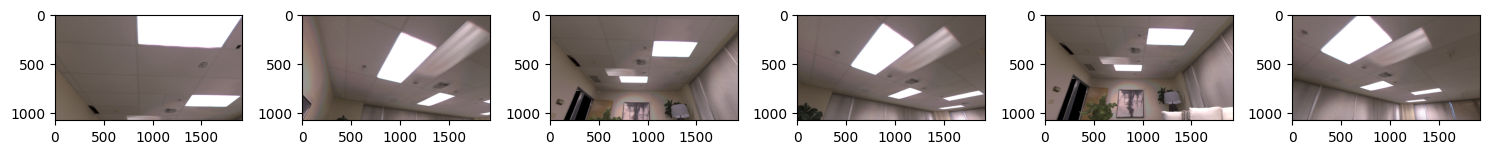

apartment_1_task/images/00008.png


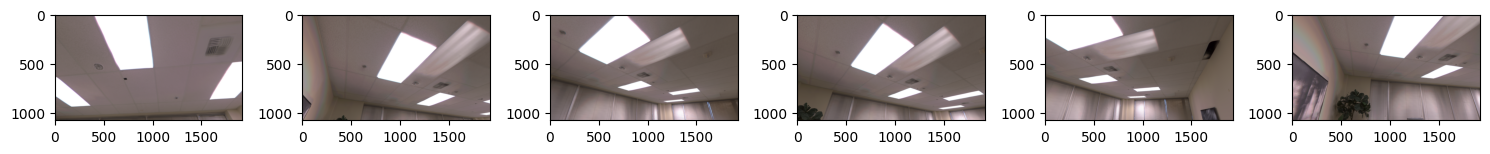

apartment_1_task/images/00010.png


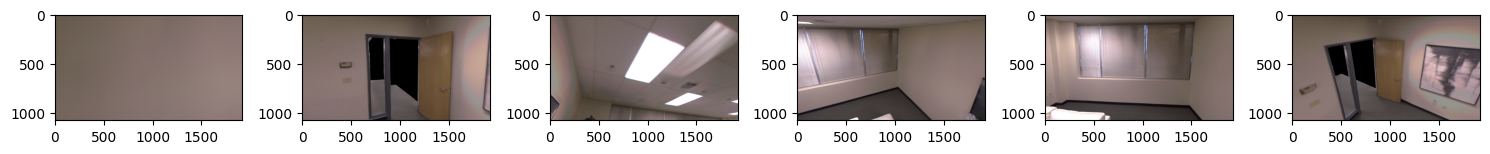

apartment_1_task/images/00011.png


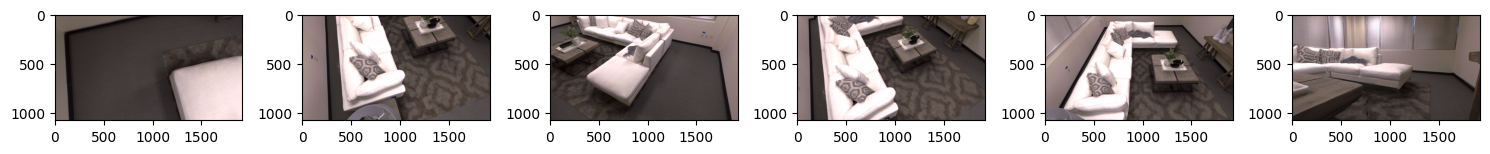

apartment_1_task/images/00014.png


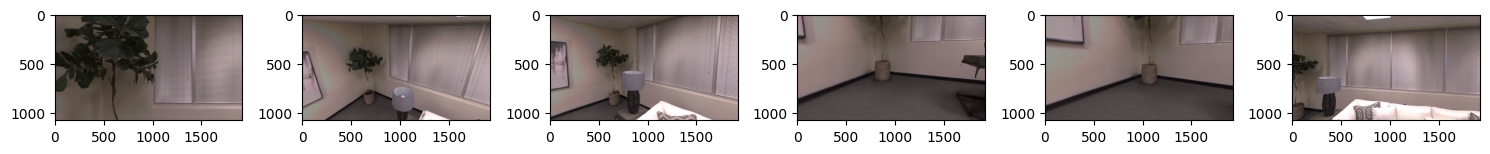

In [64]:
basedir = '/mnt/sdb1/home/kbotashev/iros_paper/replica_dataset_1/scenes'
for i, row in data_sparse_room_fail.iterrows():
    print(row['image_name'])
    query_img_path = os.path.join(basedir, row['room_name'], row['image_name'])
    query_img = imageio.imread(query_img_path)
    f, axarr = plt.subplots(1,6, figsize = (15,5))
    axarr[0].imshow(query_img)
    top5_vladnet = row['top_k_refs'].replace('[', '').replace('\n', '').replace(']', '').replace("'", '').split(' ')[:5]
    for i, topk_img_path in enumerate(top5_vladnet):
        axarr[i+1].imshow(imageio.imread(os.path.join(basedir, row['room_name'], topk_img_path)))
    plt.tight_layout()
    plt.show()

In [92]:
vladnet_base = pd.read_csv('/mnt/sdb1/home/kbotashev/iros_paper/replica_dataset_1/results_task_base_vladnet/full_results_task_base_vladnet.csv')
vladnet_rebase = pd.read_csv('/mnt/sdb1/home/kbotashev/iros_paper/replica_dataset_1/results_task_rebase_vladnet/full_results_task_rebase_vladnet.csv')

In [93]:
vladnet = pd.concat([vladnet_base, vladnet_rebase])

In [96]:
vladnet_groups = vladnet.groupby(['room_name', 'frame_name']).mean('success_combined')
vladnet_groups['success_combined'][vladnet_groups['success_combined'] == 0]

room_name    frame_name
apartment_1  3             0.0
             4             0.0
             6             0.0
             7             0.0
             8             0.0
             10            0.0
             15            0.0
             16            0.0
             18            0.0
             19            0.0
             20            0.0
             21            0.0
             26            0.0
             27            0.0
             29            0.0
             30            0.0
office_2     4             0.0
             7             0.0
             11            0.0
             13            0.0
             19            0.0
             20            0.0
             23            0.0
             28            0.0
             31            0.0
Name: success_combined, dtype: float64

In [37]:
vladnet_groups = vladnet.groupby(['room_name', 'frame_name']).mean('success_combined')
vladnet_groups['success_combined'][vladnet_groups['success_combined'] == 0]

room_name    frame_name
apartment_0  10            0.0
             12            0.0
             13            0.0
             14            0.0
             17            0.0
             21            0.0
             22            0.0
             23            0.0
             27            0.0
             31            0.0
apartment_1  1             0.0
             6             0.0
             7             0.0
             8             0.0
             9             0.0
             10            0.0
             11            0.0
             15            0.0
             19            0.0
             20            0.0
             21            0.0
             23            0.0
             29            0.0
             30            0.0
office_0     3             0.0
             10            0.0
             11            0.0
             12            0.0
             13            0.0
             30            0.0
office_2     2             0.0
             4 

In [30]:
vladnet[vladnet['success_combined'] == 0]

,Unnamed: 0,room_name,experiments_base_dir,ply_path,pickle_path,init_id,iou_bin,frame_name,camera_type,loss_type,...,converged,num_tries,success,R_result,t_result,rot_err_deg,t_error_cm,success_rot,success_t,success_combined
2,2,apartment_1,/mnt/sdb1/home/kbotashev/iros_paper/replica_da...,/mnt/sdb1/home/kbotashev/iros_paper/replica_da...,/mnt/sdb1/home/kbotashev/iros_paper/replica_da...,157,0,12,lietorch,l1,...,True,5,0,"[[-0.7895370398570165, -0.4815483087287893, -0...","[2.4079580307006836, -2.2189455032348633, 4.97...",26.776732,1.270867,0,0,0
4,4,apartment_1,/mnt/sdb1/home/kbotashev/iros_paper/replica_da...,/mnt/sdb1/home/kbotashev/iros_paper/replica_da...,/mnt/sdb1/home/kbotashev/iros_paper/replica_da...,156,0,12,lietorch,l1,...,True,5,0,"[[-0.7886001521016226, -0.4832915916094942, -0...","[2.424772024154663, -2.2455039024353027, 4.988...",26.746036,1.298456,0,0,0
6,6,apartment_1,/mnt/sdb1/home/kbotashev/iros_paper/replica_da...,/mnt/sdb1/home/kbotashev/iros_paper/replica_da...,/mnt/sdb1/home/kbotashev/iros_paper/replica_da...,114,0,16,lietorch,l1,...,True,5,0,"[[0.9203870990102654, 0.33994989952576926, 0.1...","[-1.1927540302276611, -0.3546525835990906, -0....",32.412809,2.855206,0,0,0
7,7,apartment_1,/mnt/sdb1/home/kbotashev/iros_paper/replica_da...,/mnt/sdb1/home/kbotashev/iros_paper/replica_da...,/mnt/sdb1/home/kbotashev/iros_paper/replica_da...,113,0,16,lietorch,l1,...,True,5,0,"[[0.9197817241670718, 0.3385110127320705, 0.19...","[-1.221514105796814, -0.27567166090011597, -0....",31.858975,2.862124,0,0,0
8,8,apartment_1,/mnt/sdb1/home/kbotashev/iros_paper/replica_da...,/mnt/sdb1/home/kbotashev/iros_paper/replica_da...,/mnt/sdb1/home/kbotashev/iros_paper/replica_da...,112,0,16,lietorch,l1,...,True,5,0,"[[0.9980544301094748, 0.05557790760308001, -0....","[0.5441575646400452, -0.9198409914970398, -0.8...",20.951337,1.731249,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
774,774,office_4,/mnt/sdb1/home/kbotashev/iros_paper/replica_da...,/mnt/sdb1/home/kbotashev/iros_paper/replica_da...,/mnt/sdb1/home/kbotashev/iros_paper/replica_da...,94,0,13,lietorch,l1,...,True,5,0,"[[-0.8503628002440635, 0.438435094805838, 0.29...","[0.846767246723175, -1.0984227657318115, 3.585...",119.168802,3.868497,0,0,0
782,782,office_4,/mnt/sdb1/home/kbotashev/iros_paper/replica_da...,/mnt/sdb1/home/kbotashev/iros_paper/replica_da...,/mnt/sdb1/home/kbotashev/iros_paper/replica_da...,54,0,31,lietorch,l1,...,True,5,0,"[[-0.6042126976439253, -0.6996296017913775, 0....","[1.0994060039520264, -0.6824480891227722, -1.5...",43.812455,2.764312,0,0,0
783,783,office_4,/mnt/sdb1/home/kbotashev/iros_paper/replica_da...,/mnt/sdb1/home/kbotashev/iros_paper/replica_da...,/mnt/sdb1/home/kbotashev/iros_paper/replica_da...,36,0,31,lietorch,l1,...,True,5,0,"[[-0.2715678668557828, -0.960503930304828, 0.0...","[-0.5330849289894104, 0.3902221620082855, -2.0...",8.594833,1.500121,0,0,0
791,791,office_4,/mnt/sdb1/home/kbotashev/iros_paper/replica_da...,/mnt/sdb1/home/kbotashev/iros_paper/replica_da...,/mnt/sdb1/home/kbotashev/iros_paper/replica_da...,80,0,25,lietorch,l1,...,True,5,0,"[[0.14990728704553646, -0.3576064698729553, 0....","[-0.40012505650520325, -0.5198588371276855, 1....",142.228309,3.485764,0,0,0
